# unimib/DSIM 2025-2026: Task 2

Model Training - E. Mosca 925279

After having analysed the images, a neural network architecture can be devised to capture the discriminative features that represent target response classes

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as data
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

To use the dataset, add a shortcut to our folder on your own drive, and replace the path below with the path to the dataset on your gdrive.

In [ ]:
path_on_gdrive = 'replace_with_your_gdrive_path'+'/Plant_leave_diseases_dataset_without_augmentation.zip'
dataset_filename = 'Plant_leave_diseases_dataset_without_augmentation' # do not modify, this is meant to not include the '.zip' extension in the name

Now loading gdrive:

In [ ]:
from google.colab import drive
import zipfile
from shutil import copyfile
drive.mount('/content/gdrive')
copyfile(path_on_gdrive, dataset_filename+'.zip')
zipf = zipfile.ZipFile(dataset_filename+'.zip')
zipf.extractall()
zipf.close()

Mounted at /content/gdrive


In [ ]:
dataset = ImageFolder(root=dataset_filename, transform=transforms.ToTensor())

The dataset has been loaded, below, a python file containing custom neural net classes is also loaded into the environment. Similarly to what was done above, replace the code with your path; model.py should be in the task2 folder...

In [ ]:
copyfile("gdrive/MyDrive/dsim/task2/model.py", "model.py")
from model import PlantClassifier

With what was seen during dataset exploration, we know leaves come in different orientations, so we can use data augmentation to create new training samples from existing ones, in this case "alternate orientation" images.

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomHorizontalFlip(p=0.25)
])
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

Train/val/split to prepare for model training

In [ ]:
# Stratified split into train (80%), val (10%), test (10%)
from sklearn.model_selection import train_test_split

labels = [sample[1] for sample in dataset.samples]

#80% train, 20% temp
train_indices, temp_indices = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# split the 20% into 50-50 for val (10%) and test (10%)
temp_labels = [labels[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

train_dataset = data.Subset(dataset, train_indices)
val_dataset = data.Subset(dataset, val_indices)
test_dataset = data.Subset(dataset, test_indices)

In [ ]:
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

Setting up the model through PlantClassifier class, with categorical cross entropy and adam optimizer

In [ ]:
model = PlantClassifier().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# training parameters
num_epochs = 10
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
train_dataset[0][0].shape

torch.Size([3, 256, 256])

The training code follows, we will keep track of:

- Accuracy throughout training (for train and val sets)
- loss throughout training (for train and val sets)
- Training(+validation) time.

Note that we also save a model to disk whenever the best value for loss is achieved, later we will also save the last model resulting from the whole 10 epochs.

Also note: training accuracy scale is wrong, it should be multiplied by 100, but re-running training would have consumed gpu time and energy

In [ ]:
accuracy_over_time = []
loss_over_time = []
val_acc_over_time = []
val_loss_over_time = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_accuracies = []
    training_start_time = time.time()
    for images, labels in train_loader:
        epoch_start_time = time.time()
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        train_accuracies.append((outputs.argmax(dim=1) == labels).float().mean().item())

    epoch_elapsed_time = time.time() - training_start_time
    print(f"Epoch {epoch+1} training time: {epoch_elapsed_time:.2f} seconds")
    print(f"Average time per batch: {epoch_elapsed_time/len(train_loader):.4f} seconds")
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = sum(train_accuracies) / len(train_accuracies) # * 100 ; will not print correctly
    accuracy_over_time.append(epoch_accuracy)
    loss_over_time.append(epoch_loss)


    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        inference_start_time = time.time()
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    inference_elapsed_time = time.time() - inference_start_time
    print(f"Validation inference time: {inference_elapsed_time:.2f} seconds")
    print(f"Average time per validation batch: {inference_elapsed_time/len(val_loader):.4f} seconds")
    val_epoch_loss = val_running_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_acc_over_time.append(val_accuracy)
    val_loss_over_time.append(val_epoch_loss)

    best_val_loss = 100
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        ### torch.save(model.state_dict(), 'best_model.pth') #saving best model checkpoint locally

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_loss:.4f}, '
          f'Train Accuracy: {epoch_accuracy:.2f}%, '
          f'Val Loss: {val_epoch_loss:.4f}, '
          f'Val Accuracy: {val_accuracy:.2f}%')
training_elapsed_time = time.time() - training_start_time
print(f"Total training time: {training_elapsed_time:.2f} seconds") # note that this includes various prints and computations
print(f"Average time per epoch: {training_elapsed_time/num_epochs:.2f} seconds") #that arent strictly necessary for training

Epoch 1 training time: 137.20 seconds
Average time per batch: 0.0989 seconds
Validation inference time: 11.82 seconds
Average time per validation batch: 0.0679 seconds
Epoch [1/10], Train Loss: 1.3383, Train Accuracy: 0.61%, Val Loss: 0.6197, Val Accuracy: 80.29%
Epoch 2 training time: 134.42 seconds
Average time per batch: 0.0969 seconds
Validation inference time: 11.45 seconds
Average time per validation batch: 0.0658 seconds
Epoch [2/10], Train Loss: 0.6890, Train Accuracy: 0.78%, Val Loss: 0.4012, Val Accuracy: 86.13%
Epoch 3 training time: 134.80 seconds
Average time per batch: 0.0972 seconds
Validation inference time: 11.77 seconds
Average time per validation batch: 0.0676 seconds
Epoch [3/10], Train Loss: 0.4692, Train Accuracy: 0.85%, Val Loss: 0.1983, Val Accuracy: 93.53%
Epoch 4 training time: 135.38 seconds
Average time per batch: 0.0976 seconds
Validation inference time: 11.84 seconds
Average time per validation batch: 0.0681 seconds
Epoch [4/10], Train Loss: 0.3525, Train 

Training reached quite a satisfactory result, with great performance across classes and no signs of overfitting on the training set.

In [ ]:
### torch.save(model.state_dict(), "last_model.pth") ### local save...

Converting train accuracies to same scale:

In [ ]:
acc_copy = accuracy_over_time[:]
accuracy_over_time = [acc*100 for acc in accuracy_over_time]

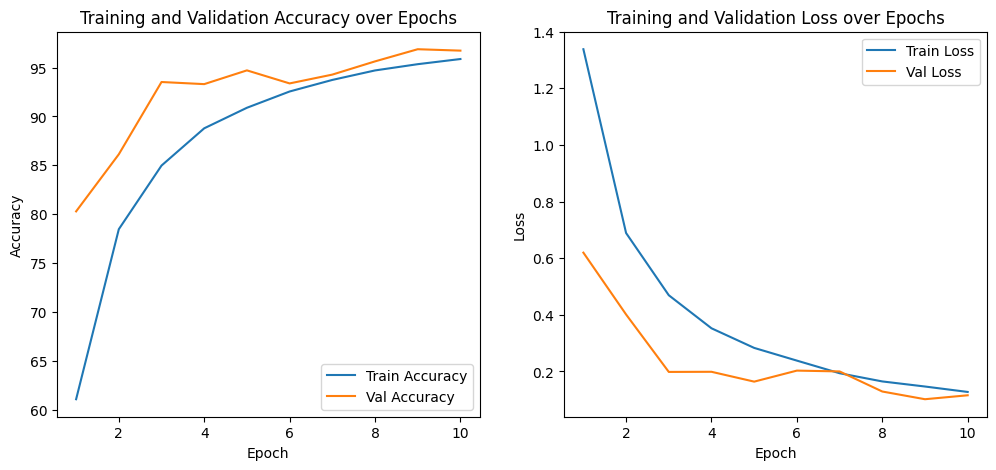

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), accuracy_over_time, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_acc_over_time, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), loss_over_time, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_loss_over_time, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

Learning curves show successful training, one thing that can be noticed is that, as the training curves leveled out, training for longer could yield a better model, but 10 epochs seem like enough.

Below, the model that achieved lowest validation loss during training(after 9 epochs) is loaded

In [ ]:
best_model = PlantClassifier().to(device)
best_model.load_state_dict(torch.load('models/best_model.pth'))

<All keys matched successfully>

In [ ]:
#inspect model size on disk
import os
model_size = os.path.getsize('models/best_model.pth') / (1024 * 1024)  # size in MB
print(f'Model size on disk: {model_size:.2f} MB')

Model size on disk: 8.07 MB


Now the model can be evaluated on a test set.

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
test_accuracies = []
test_losses = []
batch_sizes = []
best_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        test_losses.append(loss_fn(outputs, labels).item())
        test_accuracies.append((outputs.argmax(dim=1) == labels).float().mean().item())
        batch_sizes.append(len(labels))

test_accuracies_weighted = [acc * size for acc, size in zip(test_accuracies, batch_sizes)]
test_losses_weighted = [loss * size for loss, size in zip(test_losses, batch_sizes)]
print(f'Test Loss: {sum(test_losses_weighted)/sum(batch_sizes):.4f}, Test Accuracy: {sum(test_accuracies_weighted)/sum(batch_sizes)*100:.2f}%')

Test Loss: 0.1145, Test Accuracy: 96.50%


Satisfactory performance is retained also on the test set.

In [ ]:
np.mean(test_accuracies), np.min(test_accuracies), np.max(test_accuracies)

(0.9651580459770115, 0.875, 1.0)

Further evaluation:

In [ ]:
# analyze classification performance across classes
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
class_names = dataset.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.97      0.95      0.96        63
                            Apple___Black_rot       0.95      0.95      0.95        62
                     Apple___Cedar_apple_rust       0.79      1.00      0.89        27
                              Apple___healthy       0.95      1.00      0.97       164
                    Background_without_leaves       0.97      0.99      0.98       115
                          Blueberry___healthy       0.97      0.98      0.98       150
                      Cherry___Powdery_mildew       0.96      0.99      0.98       105
                             Cherry___healthy       1.00      0.84      0.91        86
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.79      0.90      0.84        51
                           Corn___Common_rust       0.99      0.99      0.99       119
                  Corn___Northern_Leaf_Bli

Classes can be discriminated quite successfully, there is no clear-cut class that the model has a hard time recognizing, and it performs well on classes with varying representation in the dataset.

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)

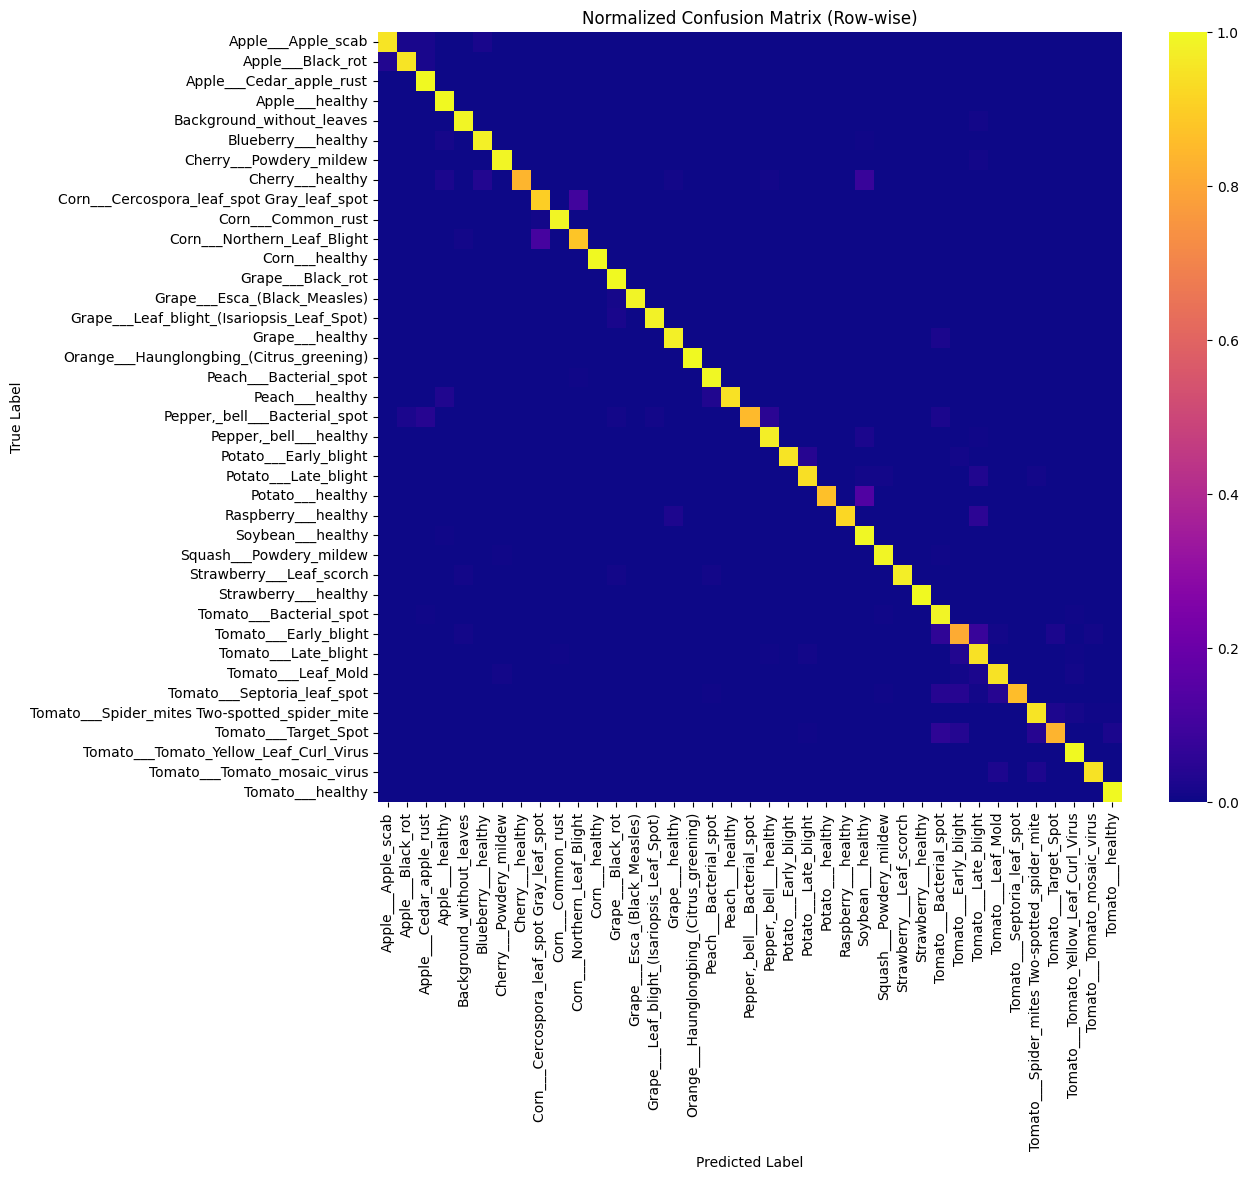

In [ ]:
# heatmap plot of confusion matrix (normalized by row to show proportions)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix_normalized, annot=False, fmt='.2f', cmap='plasma',
            xticklabels=class_names, yticklabels=class_names, vmin=0, vmax=1)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix (Row-wise)')
plt.show()

It can be seen that most classes are handled. The worst performance is visibly seen on:

- Healthy cherry, sometimes misclassified as healthy soybean, healthy apple and healthy blueberry
- Corn "gray leaf spot", misclassified as northern leaf blight (the inverse is true for northern leaf blight)
- Bell pepper bacterial spot with Apple rust and black rot, and with Potato bacterial spot. Healthy bell pepper sometimes misclassified as healthy soybean
- Healthy potato mistaken for healthy soybean

Tomato classes, the most abundant, show higher misclassifications among them:

- Yellow leaf curl virus, mosaic virus, and healthy tomato classes are ones with more solid classification.
- bacterial spot was misclassified as target spot, septoria leaf spot, early blight, healthy grape and Bell Pepper bacterial spot.
- Early blight was misclassified as bacterial spot, and interestingly late blight
- Late blight predicted as early blight
- Both tomato septoria leaf spot and target spot misclassified as bacterial spot and early blight

To sum up, the model performs accurately on average. The characteristic weaknesses are related to classifying tomato classes, and mistaking some healthy plants as healthy soybean; other than that bacterial spot which is common across plants might lead to misclassification.